# Example Exploration of Mapped Data

This notebook provides a simple set of examples of things to do with the mapped data products from the `PINK SOM`. It aims to demonstrate how to use some of the example classes and perform basic transformations, clustering and collation. Not meant to be a be-all-end-all cookbook. 

In [1]:
import pickle 
import os, shutil
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
from tqdm import tqdm
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.table import Table
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u

import networkx as nx
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
import warnings
import matplotlib
from astropy.visualization import AsinhStretch, ImageNormalize
from astroquery.skyview import SkyView

import pyink as pu

In [2]:
warnings.simplefilter('ignore', category=AstropyWarning)


custom = matplotlib._cm.cubehelix(s = 0, r=0.5)
matplotlib.cm.register_cmap(name='custom', data=custom)
matplotlib.cm.register_cmap(name='custom_r', data=matplotlib.cm.revcmap(custom))
cmap = matplotlib.cm.get_cmap('custom_r')
cmap.set_under('w')

## Datasets

A set of SOMs were trained against ~24,000 images with images from EMU and WISE W1 surveys. The input image size was 5 arcminutes. Below are the base file names that will be used to load in:
- preprocessed training images provided to PINK
- the SOM, mapping and spatial transform data files produced by PINK

The `PathHelper` is a simple utility class to help make folders and sub-folders without to much difficulty. 


In [3]:
s = 25
path = pu.PathHelper(f'Example_Exploration_{s}x{s}', clobber=True)
suffix = f'B3Circular_h{s}_w{s}_emu.bin'
image_binary = 'EMU_WISE_E95E05_Aegean_Components_Complex_EMUWISE_IslandNorm_Log_Reprojected.bin'

A quick look at the two-channel SOM across all neurons. 

(2, 1, 0, 0, 2, (25, 25), 0, 3, (2, 213, 213))
(2, 5325, 5325)


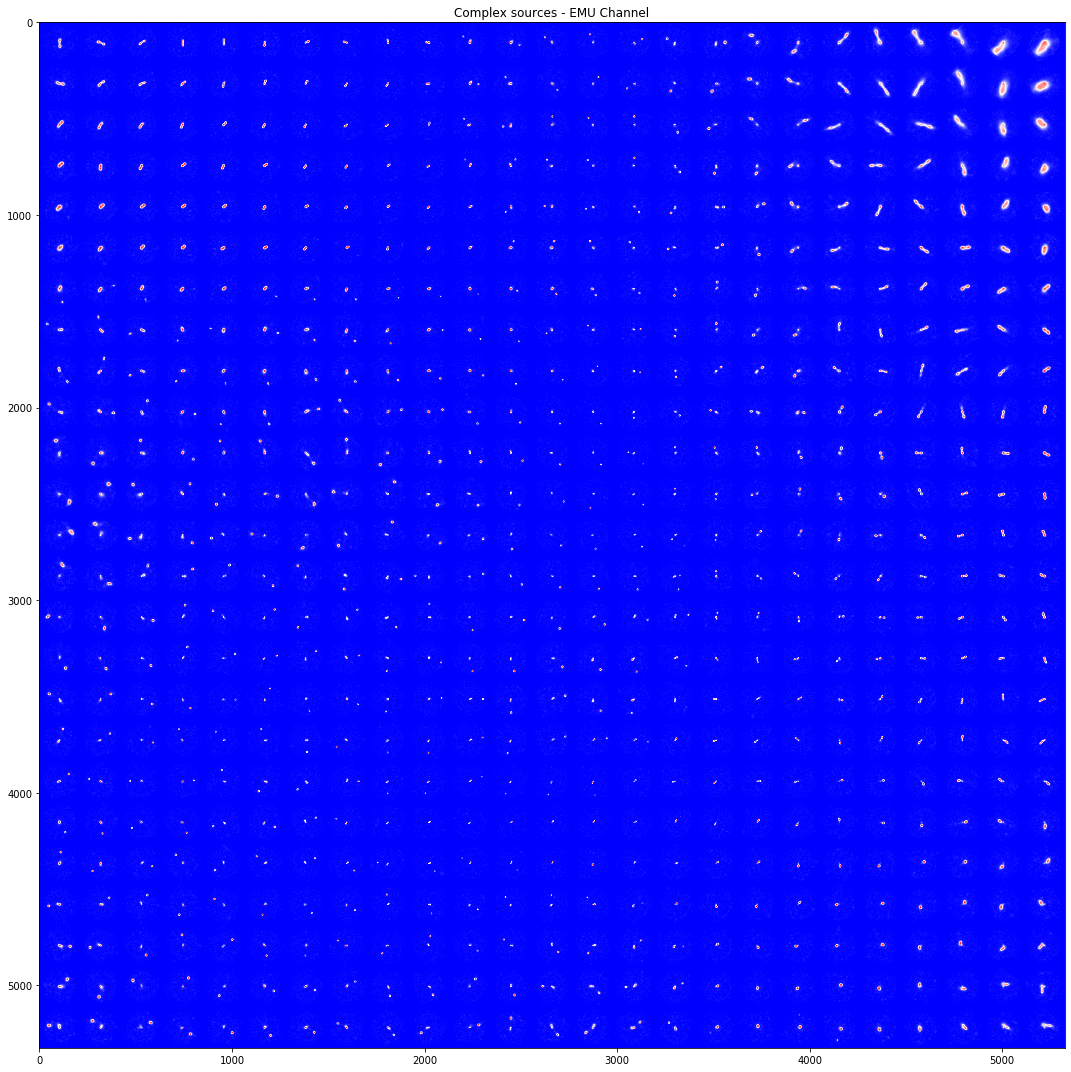

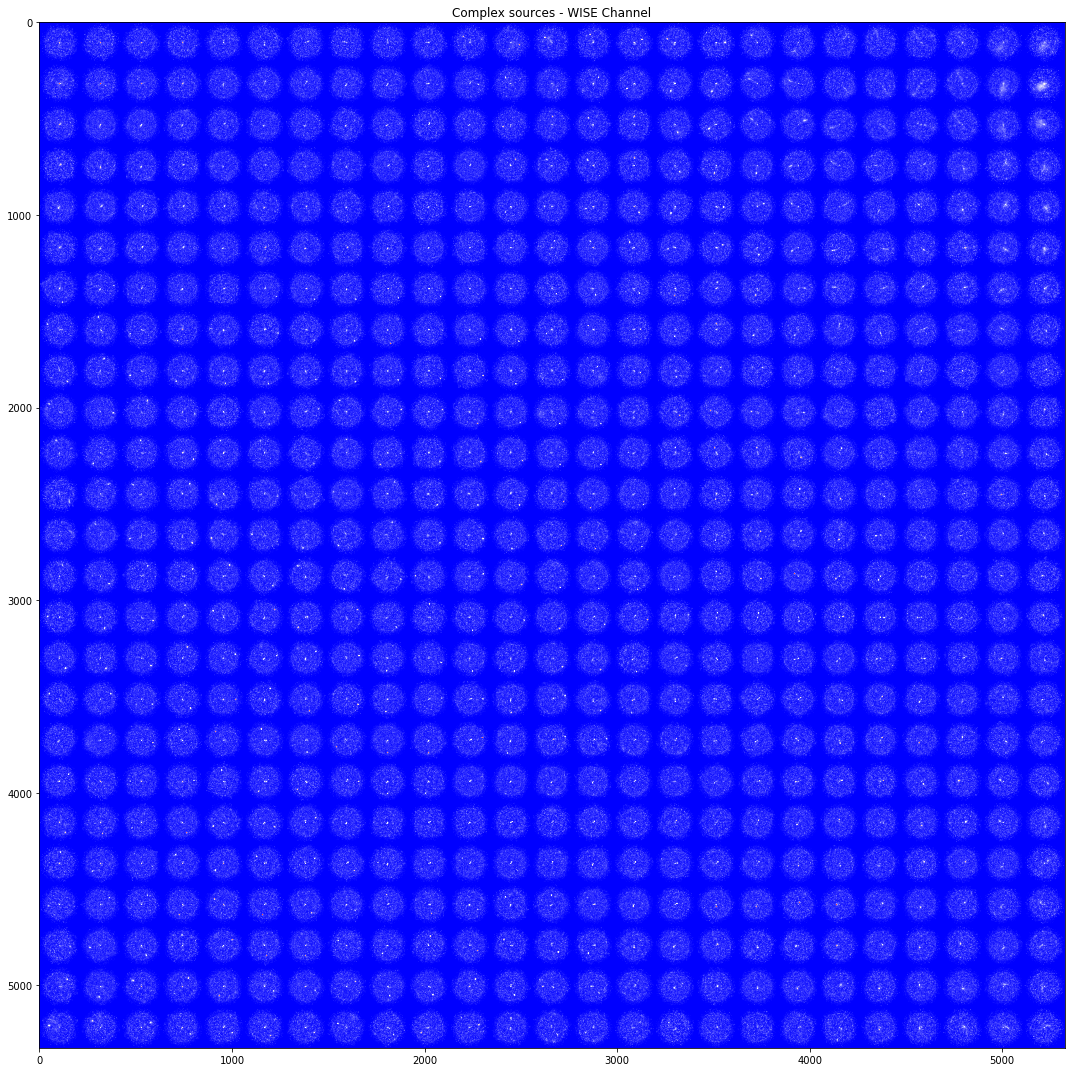

In [4]:
som = pu.SOM(f'SOMs/SOM_{suffix}')

print(som.header)
print(som.data.shape)

d = som.data.copy()

fig, ax = plt.subplots(1,1,figsize=(15,15))

ax.imshow(np.squeeze(d[0,:,:]), cmap='bwr')

ax.set_title('Complex sources - EMU Channel')
fig.tight_layout()
fig.savefig(f'{path}/EMU_Complex_EMU_Channel.png')

fig, ax = plt.subplots(1,1,figsize=(15,15))

ax.imshow(np.squeeze(d[1,:,:]), cmap='bwr')

ax.set_title('Complex sources - WISE Channel')
fig.tight_layout()
fig.savefig(f'{path}/EMU_Complex_WISE_Channel.png')



The code in the cell below will iterate over each neuron and make a corresponding figure. Note that although the input images were 5 arcminutes (150 pixels), each neuron comes out as 213x213 pixels. By default `PINK` will try to retain as much information as possible, including the outmost region where there will be inconsist image coverage that varies depending on the adopted spatial transform solution. 

Below are the first five neurons plotted. 

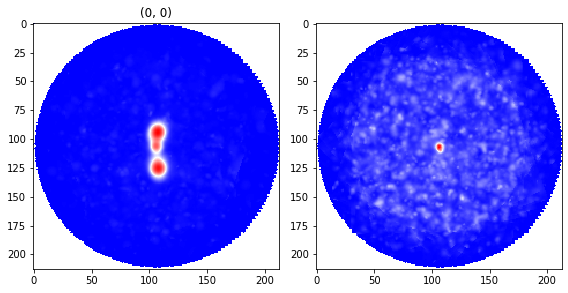

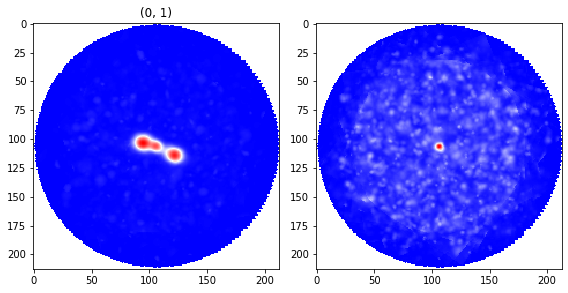

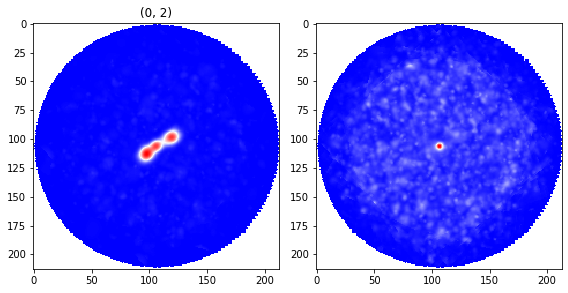

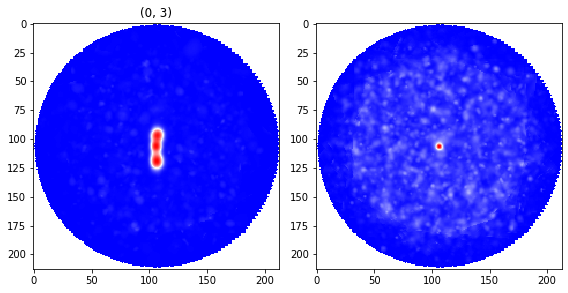

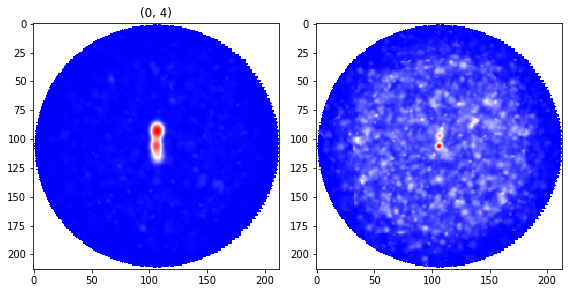

In [5]:
plt.close('all')

for i, k in enumerate(som):
    if i >= 5:
        break
        
    d = som[k].copy()

    d[d.min() == d] = np.nan
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

    ax1.imshow(np.squeeze(d[0, :,:]), cmap='bwr')        
    ax2.imshow(np.squeeze(d[1, :,:]), cmap='bwr')        
   
    ax1.set(title=k)

    fig.tight_layout()
    fig.savefig(f"{path.Neurons}/{k}.png")
    

Below we load in the mapping and spatial transform solution produced by `PINK` and create a handle to access the corresponding preprocess image binary file. 

In [6]:
transform = pu.Transform(f'SOMs/TRANSFORM_{suffix}')
print(transform.header)
print(transform.data.shape)
print('---\n')

mapper = pu.Mapping(f'SOMs/MAP_{suffix}')
print(mapper.header)
print(mapper.data.shape)
print(mapper.bmu().shape)
print('---\n')

# Container to reference the SOM, mapper and transform
som_set = pu.SOMSet(som, mapper, transform)

imgs = pu.ImageReader(image_binary, record_path='EMU_WISE_E95E05_Aegean_Components_Complex_EMUWISE_IslandNorm_Log_Reprojected.bin.order.pkl')
print(imgs.header)
print(imgs.data.shape)
print('---\n')


(2, 3, 21408, 0, 2, (25, 25))
(21408, 25, 25)
---

(2, 2, 0, 21408, 0, 2, (25, 25))
(21408, 25, 25)
(21408, 2)
---

(2, 0, 0, 21408, 0, 3, (2, 150, 150))
(21408, 2, 150, 150)
---



Each image will be most similar to a single neuron on the SOM - such a neuron is called the 'best matching unit' (BMU). Across the entire mapped set a visualisation can be made that shows how 'popular' each neuron was, as in how many times each neuron was selected as a BMU. 

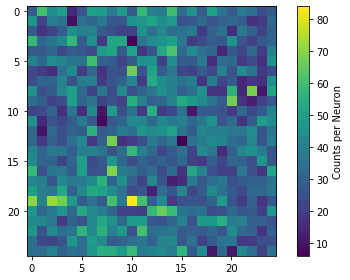

In [7]:
fig, ax = plt.subplots(1,1)

cim = ax.imshow(mapper.bmu_counts())
fig.colorbar(cim, label='Counts per Neuron')

fig.tight_layout()
fig.savefig(f'{path}/BMU_Counts.png')


# Weird images

As part of `PINK` a measure of similarity is calculated between each image an each neuron. As the SOM is constructed to represent the predominate features in a training dataset, outliers may efficently be mined by search for images that had a poor similarity. Below are the top 10 preprocessed images that had the worst similarity measure out of the training dataset. Since there has been no collation procedure applied yet some structures may be repeated more than once when there is more than one component in the component catalogue within the same island of emission. At this point this is ok (and could easily be filtered out based on catalogue island information). Many of these images appear to be giant radio lobes which occupy the majority of the input image's field of view. 

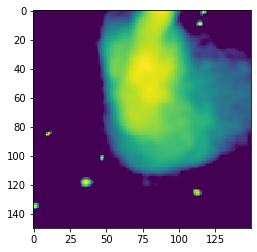

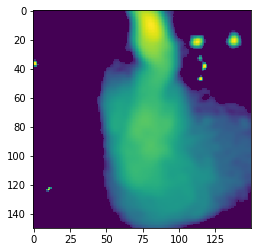

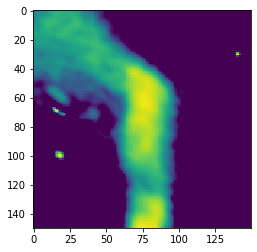

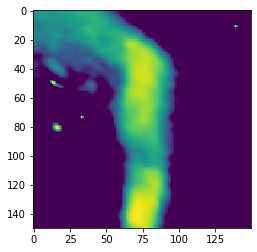

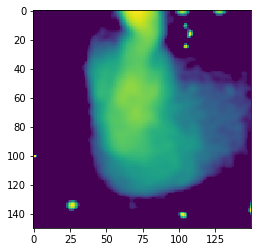

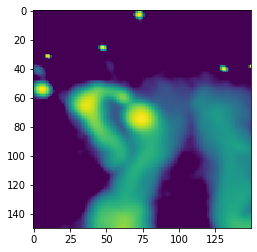

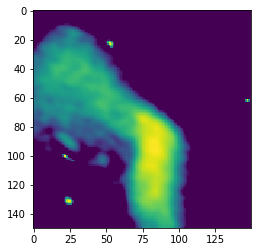

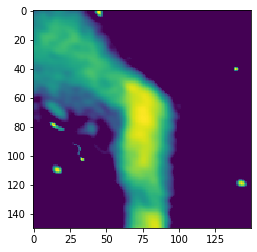

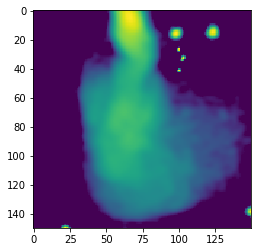

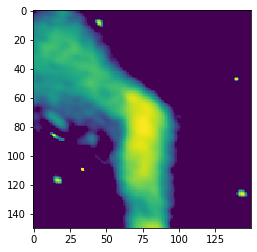

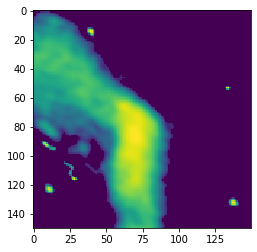

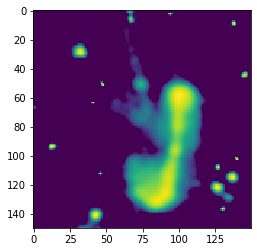

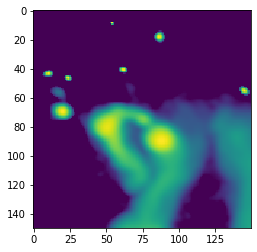

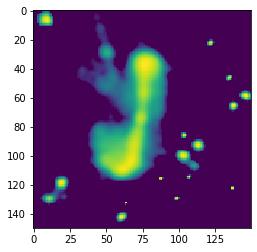

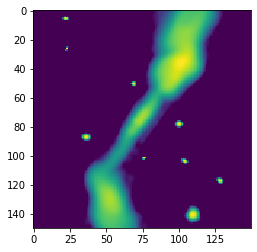

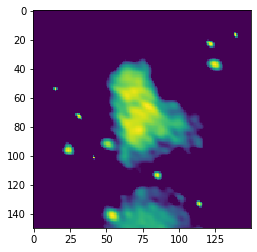

In [8]:
plt.close('all')

bad = mapper.data.reshape(mapper.data.shape[0],-1)
bad = bad.min(axis=1)
args = bad.argsort()

for i, idx in enumerate(args[::-1]):
    if i > 15:
        break
    
    fig, ax1 = plt.subplots(1,1)
    
    ax1.imshow(imgs.data[idx, 0])
    
    fig.savefig(f"{path.Weird}/weird_{i}.pdf")

# Transforming between Sky-Coordinates and neurons

A critical component of using the SOM to segment out related and unrelated features is the ability to transform sky-coordinate positions to neuron pixels positions. For each image first nearby positions within catalogue space must first be identified (i.e. for each center position across all images, find nearby catalogue positions). Then these much be transforms to pixel coordinates within an image and then transformed (with the spatial transformation solution returned by `PINK`) into the neuron reference frame.

The catalogues loaded below are (1) the EMU component catalogue of the 10 pilot fields, and (2) the AllWISE source catalogue over the same contigous patch of sky. The latter was downloaded separately through the IRSA portal (https://irsa.ipac.caltech.edu/frontpage/).

In [9]:
emu_cat = Table.read('../Data/10_field_emu/aegean/aegean_comp.fits').to_pandas()
emu_cat['uuid'] = emu_cat['uuid'].str.decode("utf-8")

wise_cat = Table.read('../Data/10_field_emu/wise_columns_subset.fits').to_pandas()


This particular SOM was trained against a sub-set of the total EMU component catalogue. Below the appropriate sub-set of rows corresponding to the training images provided to PINK are extracted. `SkyCoord` objects are then created for the catalogues. 

In [10]:
# The uuid of each source component described by aegean was saved in `records`
uuid_keys = imgs.records
emu_positions = SkyCoord(emu_cat['ra']*u.deg, emu_cat['dec']*u.deg)

# Reorders catalogue to the order images went into PINK image file
sub_emu_cata = emu_cat.set_index(keys='uuid',).loc[uuid_keys]
sub_emu_positions = SkyCoord(sub_emu_cata['ra']*u.deg, sub_emu_cata['dec']*u.deg)

wise_positions = SkyCoord(wise_cat['ra']*u.deg, wise_cat['dec']*u.deg)

Sky matches are performed below with a `seplimit` corresponding to the field of view of the circular neurons. Here, a `seplimit` is set as $2.5'$, which is the radius of these circular neurons where the is consistent image coverage. 

In [11]:
sub_emu_matches = search_around_sky(sub_emu_positions, sub_emu_positions, seplimit=5*u.arcminute/2)
wise_matches = search_around_sky(sub_emu_positions, wise_positions, seplimit=5*u.arcminute/2)

As a quick demonstration, we can take components in the sub-set of EMU components and spatially transform them to align onto an image's BMU. The code segement below retrieves an image's BMU and the corresponding spatial transformation required to aling it with the BMU. This transformation is also applied to any components near the image center (as computed in the previous snippet). The `pyink.CoordinateTransformer` handles the translation from on-sky positions, to image pixel positions, to BMU positions. We iterate across five neurons, select a source with this neuron as the BMU, and then plot. 

In special circumstances, a `WCS` object may be required for the `CoordinateTransformer` to work appropriately. Ideally, as part of the image preprocessing stage each image cutout should be reprojected to have its reference pixel at the center. Not doing this will introduce strange distortions that the naive (but faster) coordinate transform implementation does not account for. A `WCS` object may be used in place of the `pixel_scale` parameter in these cases. Note however that this information is not recorded by PINK - it would be necessary to store this information yourself. There is a `records` component in the `ImageWriter` and `ImageReader` classes that can do this, if required. 

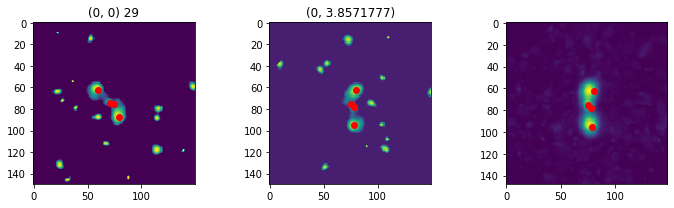

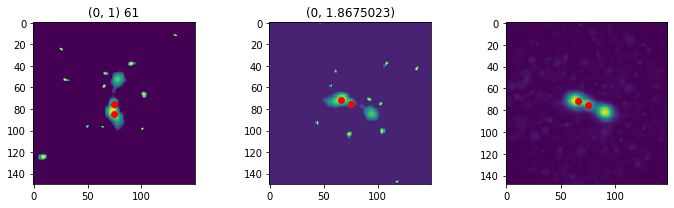

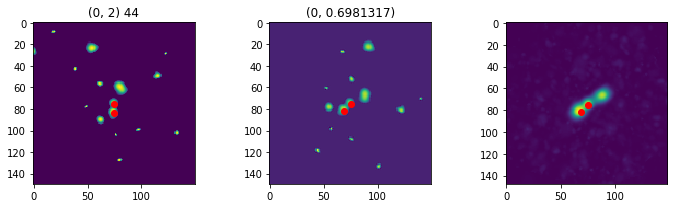

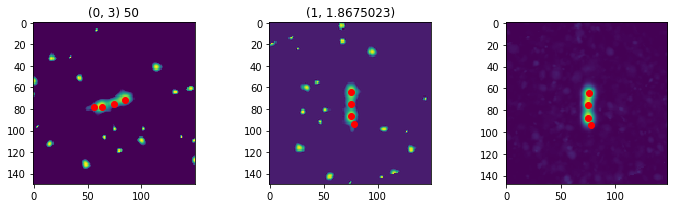

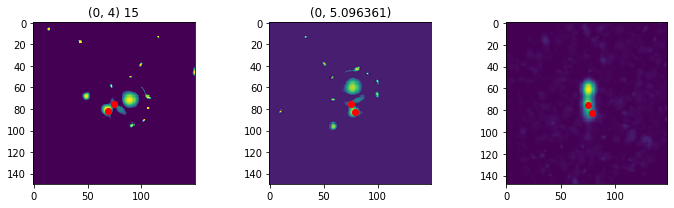

In [12]:
plt.close('all')

bmu_keys = mapper.bmu(return_idx=True, squeeze=True)
bz, by, bx = bmu_keys.T

for i, k in enumerate(som):   
    if i >= 5:
        break
        
    mask = ((k[0] == by) & (k[1] == bx))
    argmask = np.argwhere(mask)

    for j, src in enumerate(argmask):
        if j > 0:
            break
        
        src = src[0]
        
        center_pos = sub_emu_positions[src]
        src_mask = src == sub_emu_matches[0]
        src_matches = sub_emu_matches[1][src_mask]   
        
        trans_key = (src, *k)
        flip, angle = transform.data[trans_key]
        src_transform = (flip, angle)
        
        spatial_emu_pos = pu.CoordinateTransformer(center_pos,
                                                  sub_emu_positions[src_matches],
                                                  src_transform,
                                                  pixel_scale=2*u.arcsecond)
        
        src_img = imgs.data[src, 0].copy()
        transform_img = pu.pink_spatial_transform(src_img, src_transform)
    
        fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(10, 3))
        
        ax.imshow(src_img)
        ax1.imshow(transform_img)
        ax2.imshow(som[k][0][32:-33, 32:-33])

        ax.plot(spatial_emu_pos.coords['offsets-pixel'][0].value + 75, 
                spatial_emu_pos.coords['offsets-pixel'][1].value + 75,
                'ro')
        
        ax1.plot(spatial_emu_pos.coords['offsets-neuron'][0].value + 75, 
                spatial_emu_pos.coords['offsets-neuron'][1].value + 75,
                'ro')
        
        ax2.plot(spatial_emu_pos.coords['offsets-neuron'][0].value + 75, 
                spatial_emu_pos.coords['offsets-neuron'][1].value + 75,
                'ro')
        
        
        ax.set(title=f"{k} {np.sum(mask)}")
        ax1.set(title=f"{src_transform}")
        
        fig.tight_layout()
        fig.savefig(f'{path.Overlay}/{k}_{j}.png')
        

# Collecting results

For any one neuron there will be many images (and hence regions of the sky) that best match to it. Each of these images will have a *random* spatial transform to align it onto the neuron, and also a set of *random* nearby galaxies with respect to the center subject galaxy. The SOM attempts to recognise consistent features among the input training images while creating the neurons. If we were to cluster catalogue information intelligently based on (1) the best matching neuron and (2) appropriate spatial transform solution, then there should be an excess of catalogued sources coincident with the features within the neurons. If this is the case (it is), then the reduced data dimension space constructed by `PINK` could be used as a tool to help classification of catalogue space information. Annotating information on a neuron at the pixel level may be transfered back onto an image and the corresponding components in a catalogue.

Note that only the first five clustered images are made below. 

In [13]:
def accumulate(path, k, bmu_keys, som, sky_positions, sky_matches, close=True):
    bz, by, bx = bmu_keys.T
    mask = ((k[0] == by) & (k[1] == bx))
    argmask = np.argwhere(mask)

    if np.sum(mask) == 0:
        return
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
    
    ax1.imshow(np.sqrt(som[k][0]), cmap='Greys')
    ax2.imshow(np.sqrt(som[k][0]), cmap='Greys')
    
    ax1.set(title=f"{k} - {np.sum(mask)}")
    
    divider = make_axes_locatable(ax2)
    axHistx = divider.append_axes('top', size='23%', pad='2%', sharex=ax2)
    axHisty = divider.append_axes('right', size='23%', pad='2%', sharey=ax2)
    
    spatial_pos = []
    
    for j, src in enumerate(argmask):        
        src = src[0]
        
        center_pos = sky_positions[src]
        src_mask = src == sky_matches[0]
        src_matches = sky_matches[1][src_mask]   
                       
        src_transform = transform.data[(src, *k)]
        flip, angle = src_transform

        spatial_emu_pos = pu.CoordinateTransformer(center_pos,
                                               sky_positions[src_matches],
                                               src_transform,
                                               pixel_scale=2*u.arcsecond)
        
        spatial_pos.append(spatial_emu_pos)
        

    px = np.concatenate([pos.coords['offsets-neuron'][0].value for pos in spatial_pos]).flatten() + 213/2
    py = np.concatenate([pos.coords['offsets-neuron'][1].value for pos in spatial_pos]).flatten() + 213/2
    
    ax2.plot(px, py, 'ro', markersize=2., alpha=0.5)
        
    axHistx.hist(px, bins=30, density=True, histtype='stepfilled', alpha=0.7)
    axHisty.hist(py, bins=30, density=True, orientation='horizontal', histtype='stepfilled', alpha=0.7)
    axHistx.set(ylabel='Density')
    axHisty.set(xlabel='Density')
    
    # no labels
    plt.setp(axHistx.get_xticklabels(), visible=False)
    plt.setp(axHisty.get_yticklabels(), visible=False)
    
    fig.tight_layout()
    fig.savefig(f'{path.Cluster}/{k}_cluster.png')
        

In each figure below, a red marker represents a catalogue component position from the sub-set of EMU components. They are clustered around the same image features created by PINK. Marginal distributions across both spatial axis also highlight this clustering. The title on each left panel indicates (1) which neuron of the SOM this is, and (2) the number of images with this neuron as its BMU. 

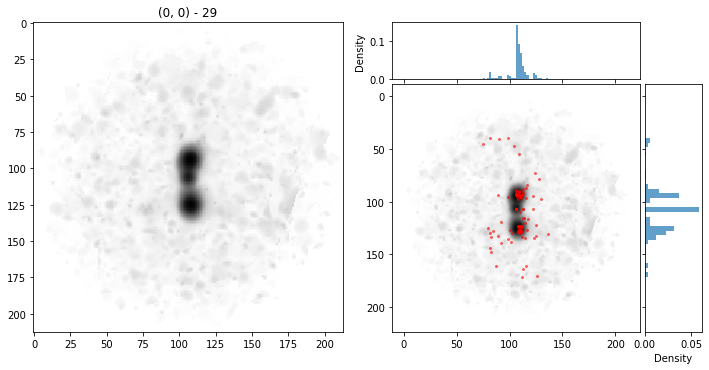

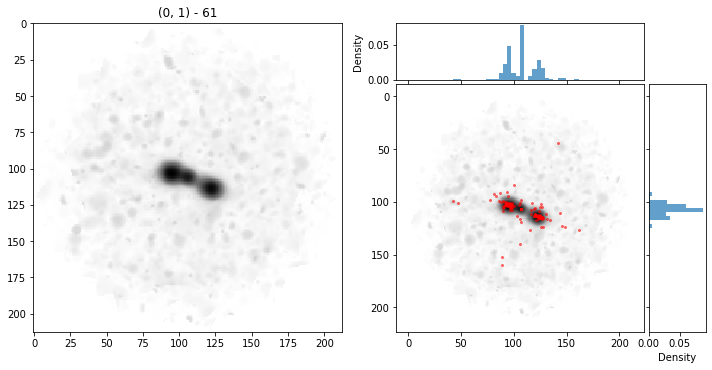

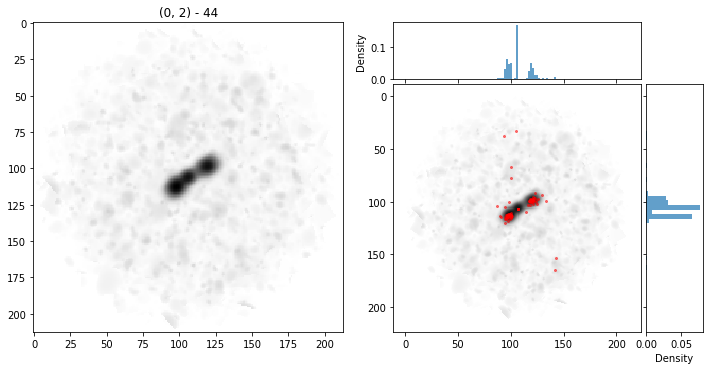

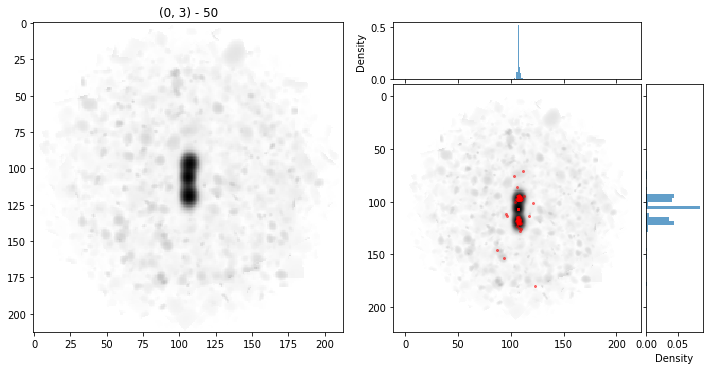

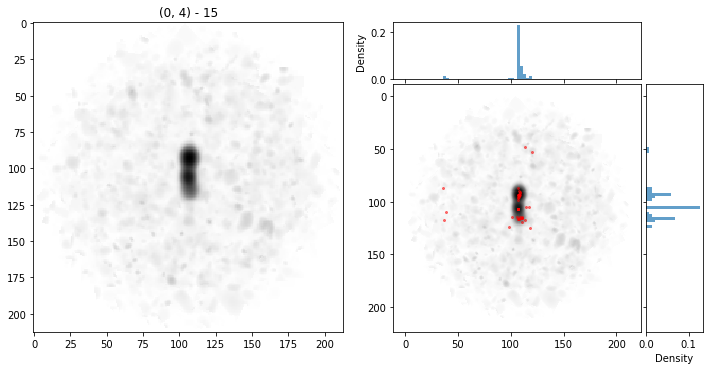

In [14]:
plt.close('all')

bmu_keys = mapper.bmu(return_idx=True, squeeze=True)

for i, k in enumerate(som): 
    if i >= 5:
        break
        
    accumulate(path, k, bmu_keys, som, sub_emu_positions, sub_emu_matches)
    

# Annotations

An interactive annotation tool (`pyink.Annotator`) was run against the 25x25 SOM used throughout this notebook. Each neuron was inspected and manually annnotated. These labels correspond to regions of each neuron, and were constructed with either a flood filling process, or with a manually region being manually drawn. For this example, each annotated region should have a label (i.e. no regions just drawn with meaning being attached). 

The code snippet below does two things. The first is loading this annotation information in. The use of the `results` parameter will instruct the `pyink.Annotator` to load an existing annotation set. If required, these can be updated on a per neuron basis. Otherwise, the `pyink.Annotator` can be used to provide an interface to interactively annotate (see `pyink.Annotator.interactive_annotation` and the example script in the repository). 

Secondly, the loop will review each annotated neuron to ensure that there are no regions defined that don't carry with them a correspopnding label. Under the hood, each filter is encoded as a numpy array of `np.int64`s. Each label is assigned a prime number. The value assigned to a pixel is the product of the corresponding labels assigned to that pixel. A value of `1` corresponds to a region with no label, and a value of `0` corresponds to no regions assigned. 

In [15]:
annotation = pu.Annotator(som.path, results='SOMs/SOM_B3Circular_h25_w25_emu.bin.results.pkl')

for k, f in annotation.results.items():
    for i, (kk, ff) in enumerate(f.filters.items()):
        if np.sum(ff == 1) > 0: # 1 correspponds to a region without a label. There should be none.
            print(k)
            
            fig, (ax1, ax2) = plt.subplots(1,2)
            
            ax1.imshow(ff)
            ax2.imshow(f.neuron[i], cmap='bwr')            
            ax2.set_title(i)
            
print('Finished, hopefully there should be no figures. ')   

Finished, hopefully there should be no figures. 


# Projecting the filters

The annotated neurons form the basis of the source collation procedure. The `pyink.FilterSet` object implements the same `CoordinateTransformer` operations to project catalogue information through the annotated filters, and returned a record of the corresponding labels assigned. It will perform the (1) on-sky matching step performed earlier, (2) identification of the BMU of each image, (2) retrieval of the corresponding spatial transformation information produced by PINK, and (4) coordinate transformations. This may take a few moments to perform for all images across all channels. It is therefore helpful to use `tqdm` to monitor the progress, which is enabled with `progress=True`. In principal, this process can be accelerated across many cores, as each filter projection does can be performed independently. This particular multi-processing feature has not been implemented yet (and if the `no_cpu` option is invoked a `NotImplemented` error will be raised). 

In [16]:
filters = pu.FilterSet(sub_emu_positions, 
                       (sub_emu_positions, wise_positions), 
                       annotation, 
                       som_set, 
                       seplimit=2.5*u.arcminute, 
                       progress=True, 
                       pixel_scale=2*u.arcsecond)

print(f"Number of matches are: {[len(fs[0]) for fs in filters.sky_matches]}")

100%|██████████| 21408/21408 [02:30<00:00, 142.19it/s]

Number of matches are: [63082, 2026256]


We can quickly inspect the results of the projection of the filters for a set of example images. Below we select five random images, five images with good matches to their BMU and five images with bad matches to their BMU. Each panel will show the filters constructed in the annotation process, where sources fell during the projection, and the input images that were used. Throughout left columns are EMU images and right are WISE W1 images (with preprocessing operations applied). 

The `pyink.Sorter` object orders source images follow a set of predefined modes, and is explained further below. 

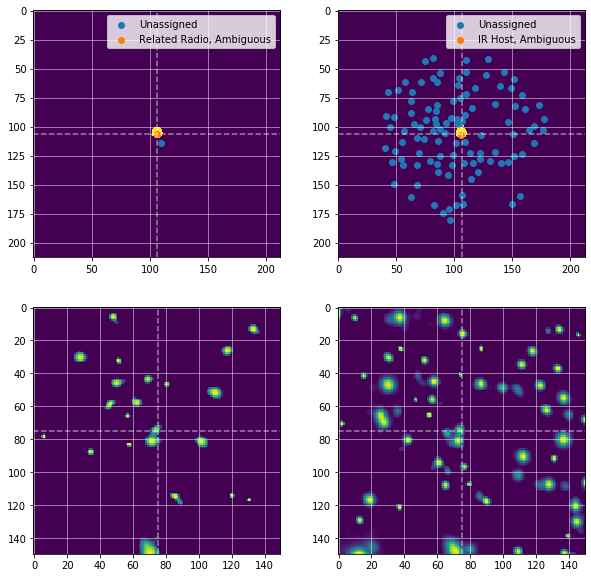

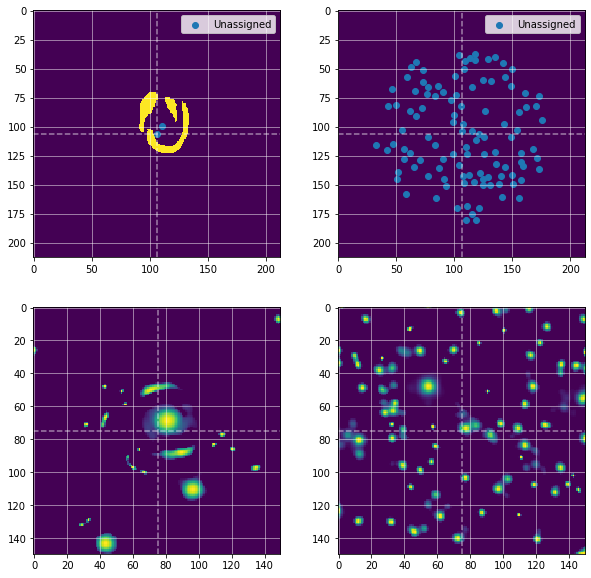

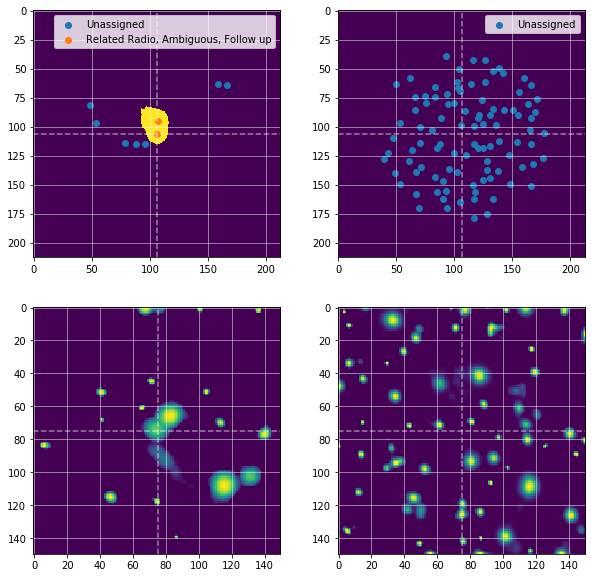

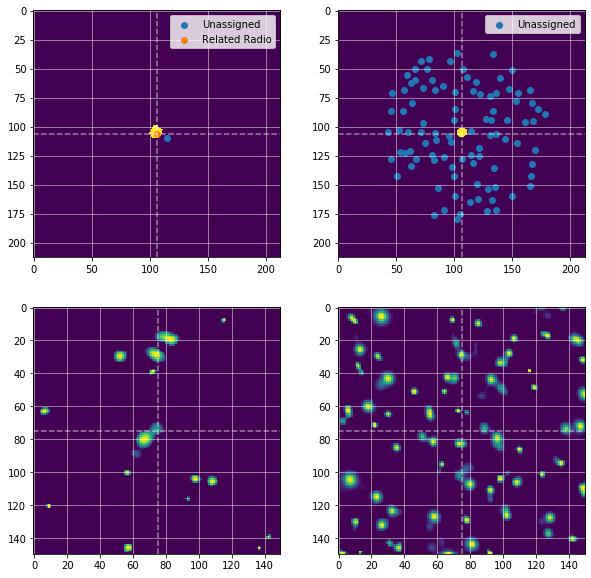

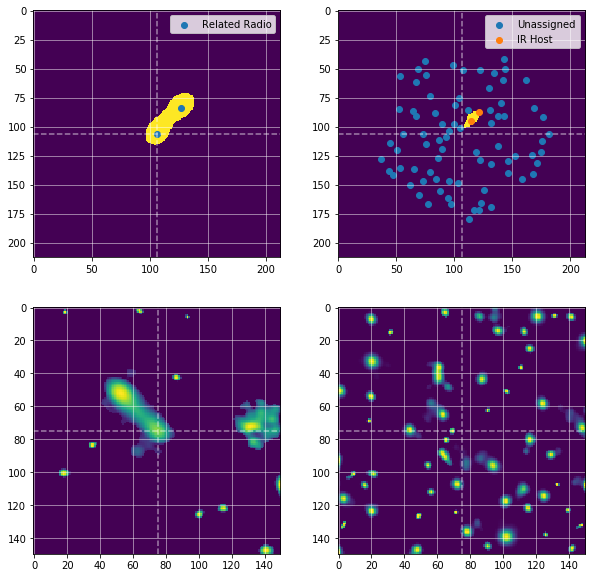

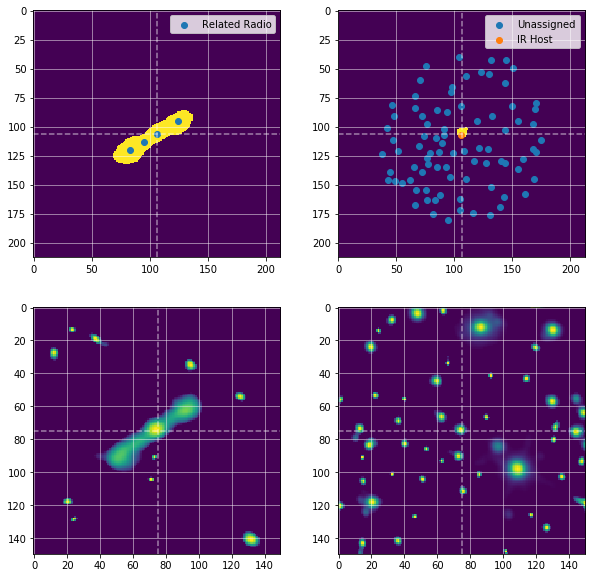

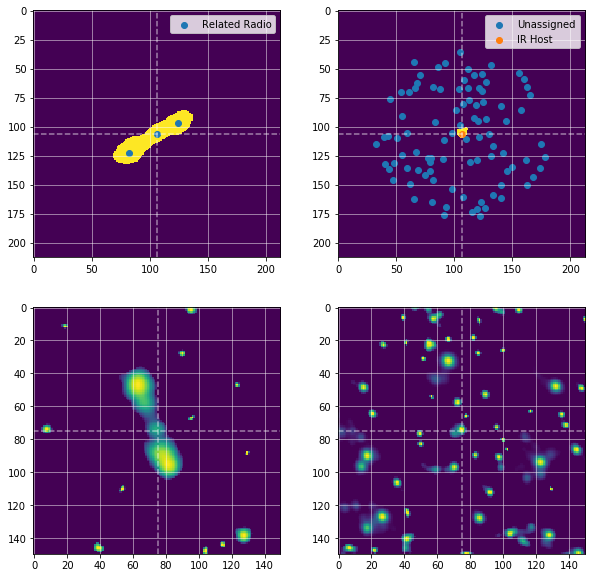

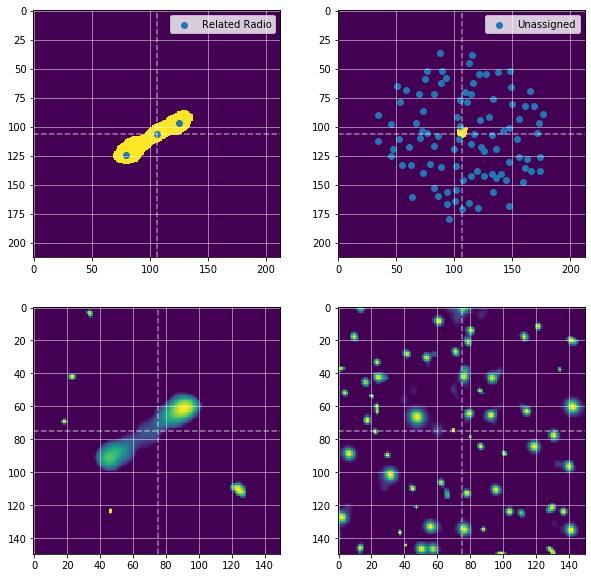

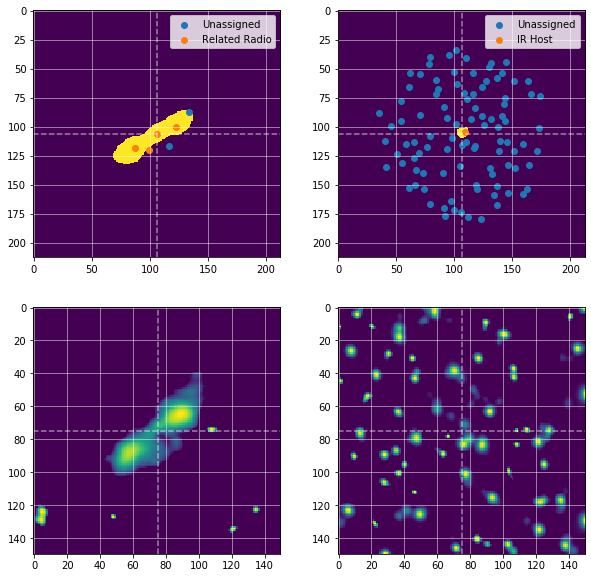

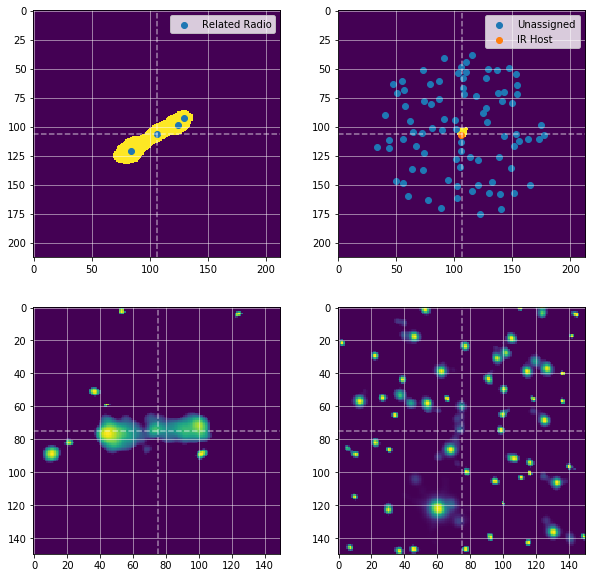

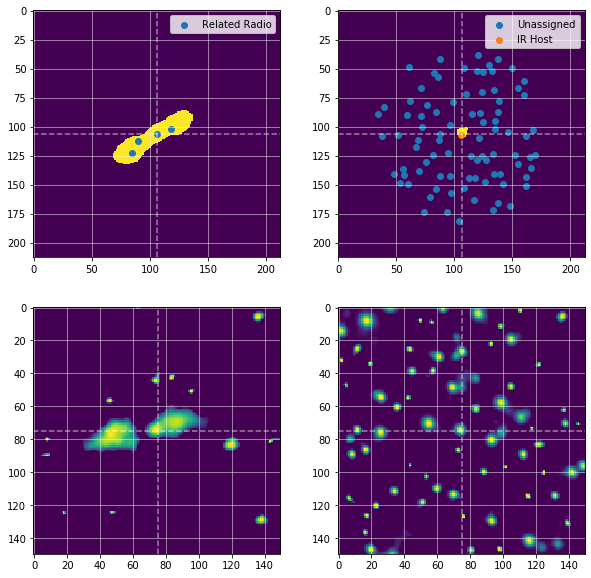

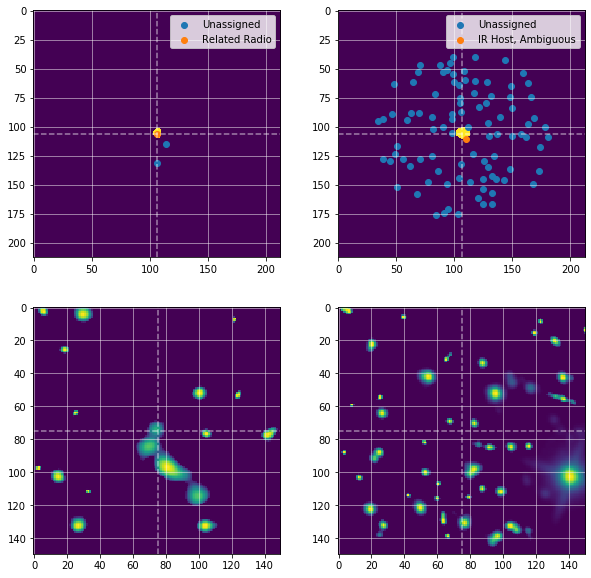

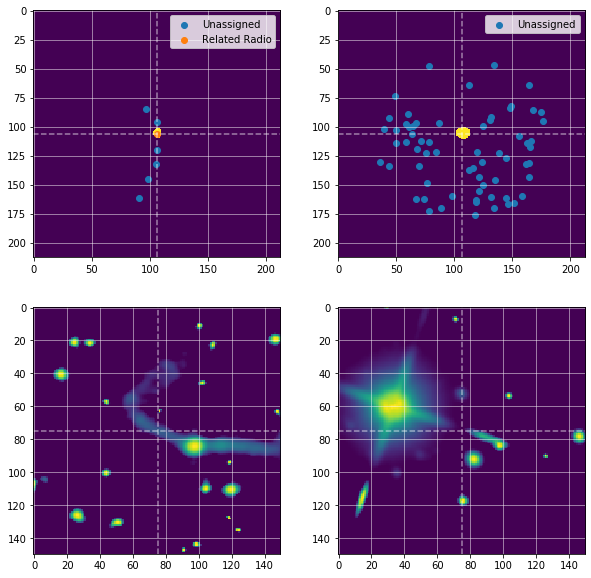

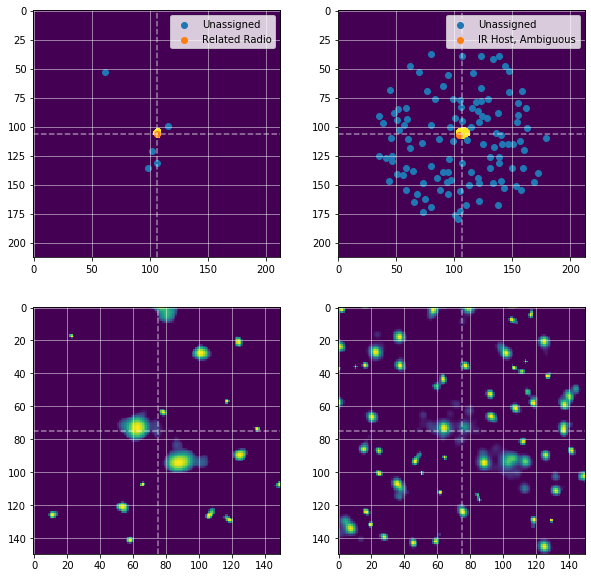

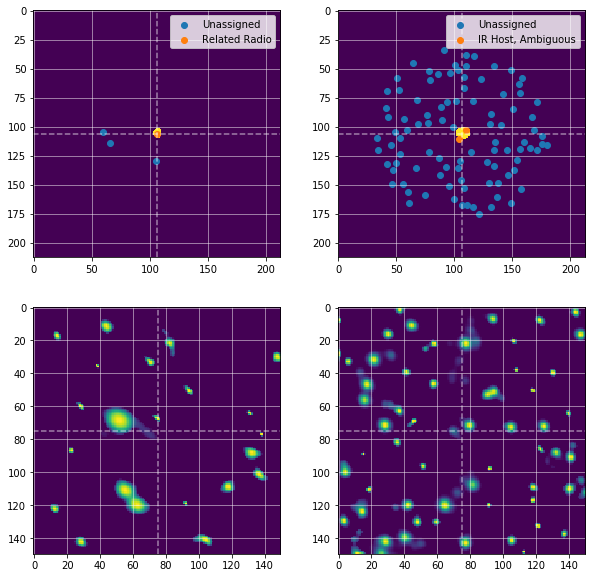

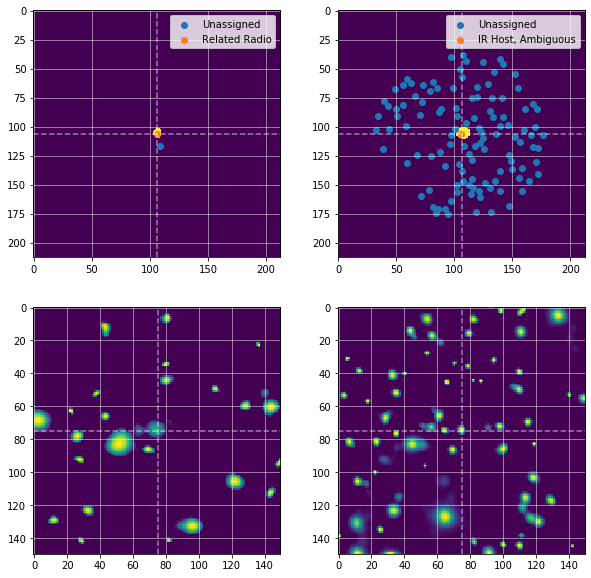

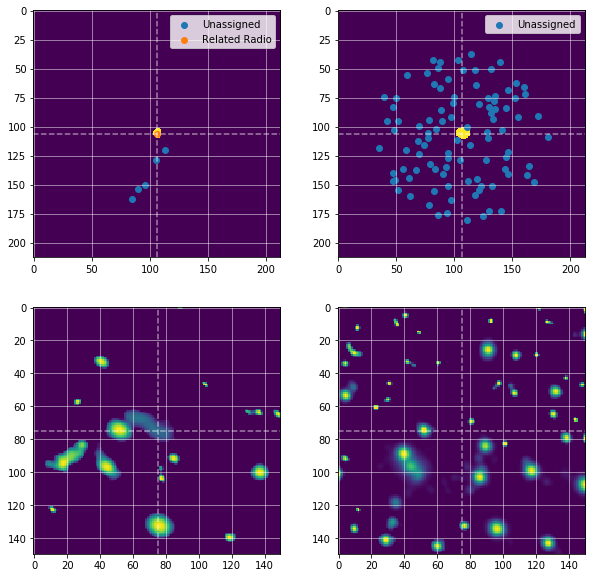

In [17]:
plt.close('all')

np.random.seed(42)

random_idxs = np.random.randint(0, 20000, size=5)

sorter = pu.Sorter(som_set, annotation, mode='area_ratio')
path = path.Area_Ratio

best_idxs = sorter[:6]
worst_idxs = sorter[-6:]

for idxs, label in zip([random_idxs, best_idxs, worst_idxs], ['random', 'sorted_ed', 'sorted_ed_bad']):
    for c, idx in enumerate(idxs):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,  figsize=(10, 10))

        filter_size = filters.filters[0][idx].neuron.filters[0].shape
        img_size = imgs.data[idx, 0].shape

        filters.filters[0][idx].plot(axes=ax1)
        filters.filters[1][idx].plot(axes=ax2)

        ax3.imshow(imgs.data[idx, 0])
        ax4.imshow(imgs.data[idx, 1])

        for ax in [ax1, ax2, ax3, ax4]:
            ax.grid(which="major", axis="both", color="white", alpha=0.6)
        for ax in [ax1, ax2]:
            ax.axvline(filter_size[0] / 2, color="white", ls="--", alpha=0.5)
            ax.axhline(filter_size[1] / 2, color="white", ls="--", alpha=0.5)
        for ax in [ax3, ax4]:
            ax.axvline(img_size[0] / 2, color="white", ls="--", alpha=0.5)
            ax.axhline(img_size[1] / 2, color="white", ls="--", alpha=0.5)

        fig.savefig(f"{path.Filter_Projections}/{label}_{c}_{idx}.png")
        

# Collating results

There is no a-priori knowledge about what radio components are related or not related to one another. For instance, in the case of a highly resolved radio galaxy with extended radio lobes, there might be three individual islands of radio emission. Hence, each island (and the components within it) would be mapped onto the SOM separately, and would have their own filters. A mechanism is needed to bring this information together. 

In an effort to efficently tackle this problem, we introduce an idea of a 'greedy graph'. The aim is to group together as many catalogue components with as few mappings as possible. A `networkx` graph is used to help manage this process, an identify related groups of catalogue information. We treat each EMU component as a node on the graph. Applying an edge between two nodes 'links' them together as a single source. Information related to the node (i.e. EMU component) may be attached to the NODE. Information related to the group (rather, object that produced the radio emission) may be tied to the edges. 

A greedy graph is implemented in the `pyink.Grouper` object. It operates against a set of predefined actions that are defined in the `pyink.Action` class. Labels that are contained in the annotation set are assigned an action. 

To drive the greedy graph, a `pyink.Sorter` object is used. It directs the graph to select the next filter from the `FilterSet` results. One can imagine there are multiple ways of driving this process - should images centered on radio lobes go first, or should images centered on the (presumed) host galaxy? Some neurons are more useful than others, and in the example the latter set of sources are often more useful as their would provide a more complete view of the radio structure. 

In the below example, the `Sorter` will arrange neurons based on the ratio of the EMU filter to the WISE filter, with larger ratios being viewed first. There are other sorting modes that are explained in the `Sorter` documentation. 

In [18]:
print(annotation.unique_labels())

actions = pu.LabelResolve({'Follow up':pu.Action.PASS, 
                           'Ambiguous':pu.Action.PASS, 
                           'Related Radio':pu.Action.LINK,
                          'Sidelobes':pu.Action.ISOLATE, 
                           'IR Host':pu.Action.DATA_ATTACH, 
                           'One Jet':pu.Action.NODE_ATTACH})

sorter = pu.Sorter(som_set, annotation, mode='area_ratio')


['Related Radio', 'One Jet', 'IR Host', 'Ambiguous', 'Sidelobe', 'Follow up']


The `Grouper` brings all these things together to produce a `networkx` graph that can be inspected. If necessary additional information may be computed and attached to an edge based on a user defined function. 

In [19]:
def src_fn(idx):
    return{'idx': idx*2,
           'bmu': som_set.mapping.bmu(idx)}

group = pu.Grouper(filters, annotation, actions, sorter, src_stats_fn=src_fn, progress=True)

21408it [00:02, 9877.25it/s] 


# Plotting the images

Below we spend some time creating images to look at the results. Each connected set of nodes and edges contain the information to plot figures and any information attached. 

Note however that when reading of the graph the largest collated sources (by the number of grouped EMU components) are read off first. These often correspond to highly resolved radio galaxies with curious and unique morphologies. They may not necessarily be the best to highlight the performance of the collation process, but they are often the most interesting. Extra information may be provided to the `Grouper` through the use of annotated labels and resolved actions to handle these differently. 

In [20]:
def get_src_img(pos, survey, angular=None, level=0, **kwargs):
    if level > 5:
        print('Failing')
        raise ValueError("Too many failed attempts. ")
    
    if survey == "first":
        survey = "VLA FIRST (1.4 GHz)"
    elif survey == 'wise':
        survey = "WISE 3.4"
    
    if angular is None:
        FITS_SIZE = 5*u.arcmin
    else:
        FITS_SIZE = (angular).to(u.arcsecond)
    
    CELL_SIZE = 2.*u.arcsec/u.pix
    imsize = FITS_SIZE.to('pix', 
                          equivalencies=u.pixel_scale(CELL_SIZE))
        
    try:
        images = SkyView.get_images(pos, 
                                    survey,
                                    pixels=int(imsize.value),
                                    width=FITS_SIZE, 
                                    height=FITS_SIZE,
                                    coordinates='J2000')
    except:
        import time
        time.sleep(4)
        get_src_img(pos, survey, angular=angular, level=level+1)

    return images[0]

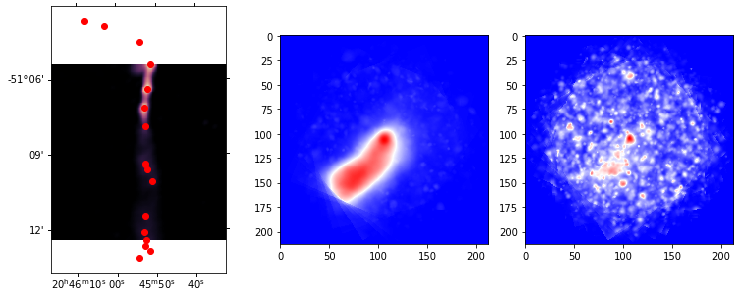

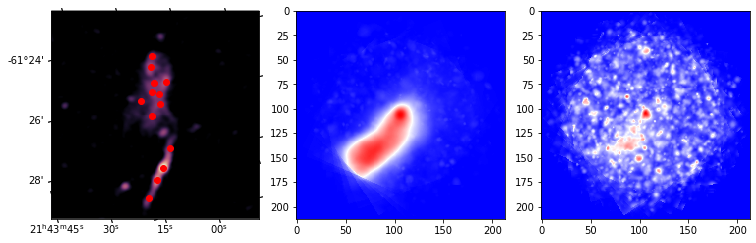

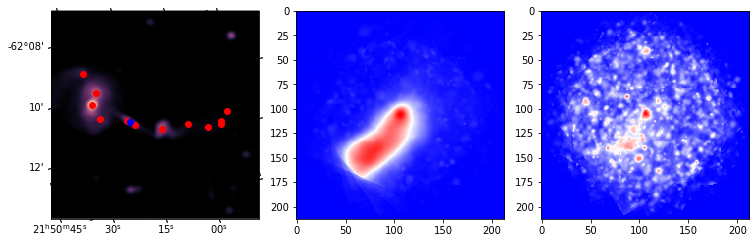

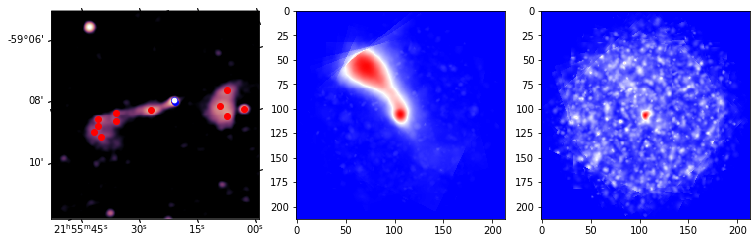

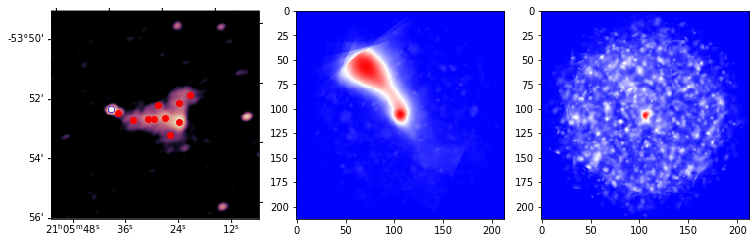

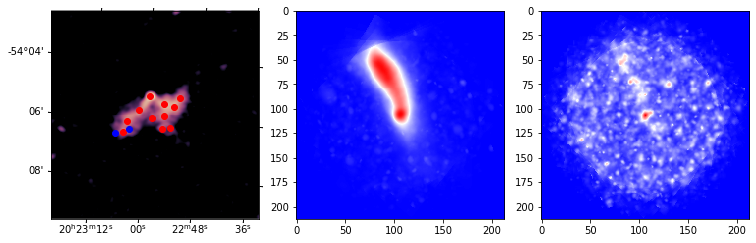

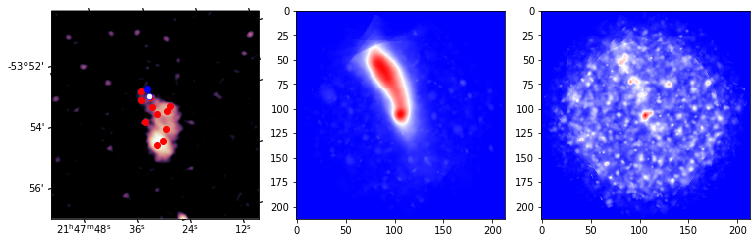

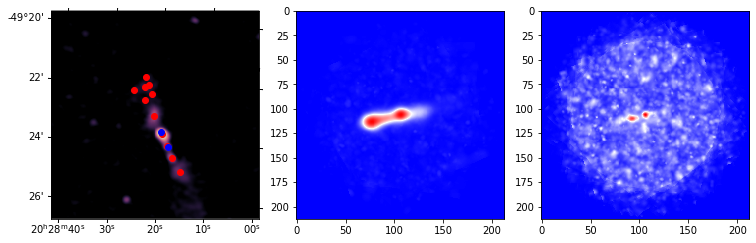

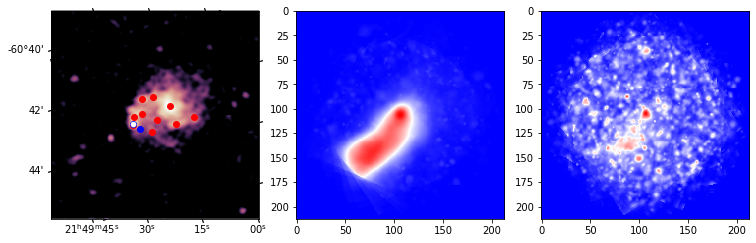

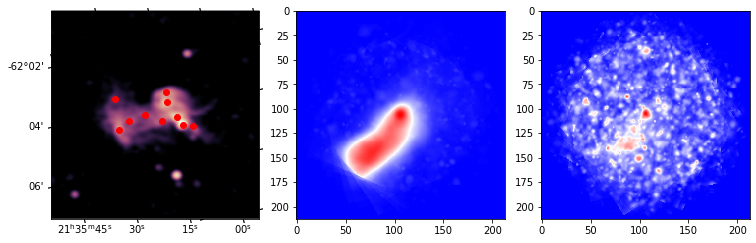

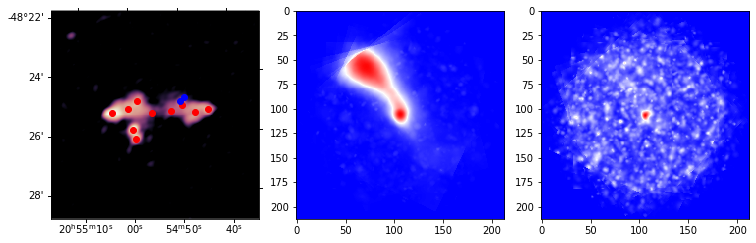

In [21]:
G = group.graph

plt.close('all')

emu_fits = fits.open('../Data/10_field_emu/image.i.emu-pilot-ten-tile.cont.taylor.0.restored.fits', 
                     memmap=True)
emu_img = np.squeeze(emu_fits[0].data)
emu_wcs = WCS(emu_fits[0].header).celestial

plt.close('all')
length = 10

for i, subg in enumerate(sorted(nx.connected_components(G), key=lambda x: len(x), reverse=True)):
    subg = list(subg)
    
    data = [d for d in G.edges(nbunch=subg, data=True)]
    data = min(data, key=lambda x:x[2]['count'])
    
    ir_hosts = data[2]['IR Host']
    bmu = tuple(data[2]['bmu'])
    
    components = sub_emu_positions[np.array(subg)]
    wise_srcs = wise_positions[ir_hosts]
    
    node_data = [G.nodes(data=True)[d] for d in subg]
    
    onejet = any([d['onejet'] for d in node_data if 'onejet' in d.keys()])
    
    if i > length:
        break
    
    mean_component = SkyCoord(components.cartesian.mean())
    emu_cutout = Cutout2D(emu_img, mean_component, size=7*u.arcminute, wcs=emu_wcs)
    
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(131, projection=emu_cutout.wcs)
    
    rms_estimate = pu.rms_estimate(emu_cutout.data)
    norm = ImageNormalize(stretch=AsinhStretch(), vmin=2*rms_estimate, vmax=0.9 * np.nanmax(emu_cutout.data))
    
    ax.imshow(emu_cutout.data,
              norm=norm,
              cmap='custom')
    ax.scatter(components.ra, 
               components.dec, 
               transform=ax.get_transform('world'), 
               color='red')
    
    ax.scatter(wise_srcs.ra, 
               wise_srcs.dec, 
               transform=ax.get_transform('world'), 
               color='blue')
    
    likely_host=False
    sky_matches = search_around_sky(components, wise_srcs, seplimit=15*u.arcsecond)
    if len(sky_matches[0]) > 0:
        best_match = np.argmin(sky_matches[2])
        best_wise_match = wise_srcs[sky_matches[1][best_match]]
        
        # Obtained from cross-matching a shifted catalogue to WISE
        if sky_matches[2][best_match] < 3.4*u.arcsecond:
            ax.scatter(best_wise_match.ra, 
                       best_wise_match.dec, 
                       transform=ax.get_transform('world'), 
                       color='white',
                       s=22)
            likely_host = True

    if onejet:
        ax.set_title('Potentially Large Lobe')
    
    ant = annotation.results[bmu]
    
    ax = fig.add_subplot(132)
    ax = ax.imshow(ant.neuron[0], cmap='bwr')
    
    
    ax = fig.add_subplot(133)
    ax = ax.imshow(ant.neuron[1], cmap='bwr')
    
    fig.tight_layout()
    
    if likely_host:
        fig.savefig(f"{path.Collation.Likely_IR}/{i}.png")
        
    if len(ir_hosts) > 5:
        fig.savefig(f"{path.Collation.Unconstrained_IR}/{i}.png")
    elif len(ir_hosts) == 0:
        fig.savefig(f"{path.Collation.No_IR}/{i}.png")
    else:
        fig.savefig(f"{path.Collation.Acceptable_IR}/{i}.png")
    

## SkyPath

The `pyink.SkyPath` object will attempt to work out some statistics between the collated EMU components, including the angular extent of the object and the amount of curvature amoung the collated components. Part of this process is the derivation of a shortest path, which can be an exceptionally hard problem to solve (search for the 'traveling salesman problem' if interested). To ensure it completes in a reasonable time, a maximum iteration count is enforced when searching for an optimal solution. If sufficently high the returned shortest path should be sufficent for most purposes. 

/Users/gal16b/Documents/Postdoc_Work/EMU_SOM/pyink/pyink/skypath.py:72: UserWarning: Maximum iterations of 2000000 while searching for the best path. 
  warnings.warn(f"Maximum iterations of {max_iterations} while searching for the best path. ")
/Users/gal16b/Documents/Postdoc_Work/EMU_SOM/pyink/pyink/skypath.py:72: UserWarning: Maximum iterations of 2000000 while searching for the best path. 
  warnings.warn(f"Maximum iterations of {max_iterations} while searching for the best path. ")
/Users/gal16b/Documents/Postdoc_Work/EMU_SOM/pyink/pyink/skypath.py:72: UserWarning: Maximum iterations of 2000000 while searching for the best path. 
  warnings.warn(f"Maximum iterations of {max_iterations} while searching for the best path. ")
/Users/gal16b/Documents/Postdoc_Work/EMU_SOM/pyink/pyink/skypath.py:72: UserWarning: Maximum iterations of 2000000 while searching for the best path. 
  warnings.warn(f"Maximum iterations of {max_iterations} while searching for the best path. ")


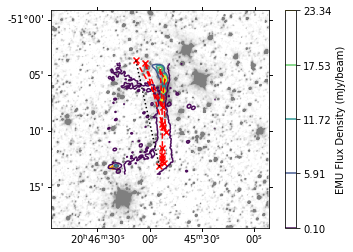

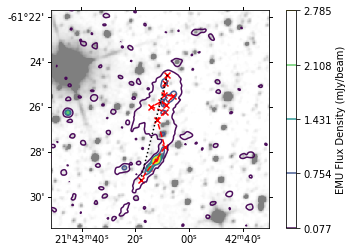

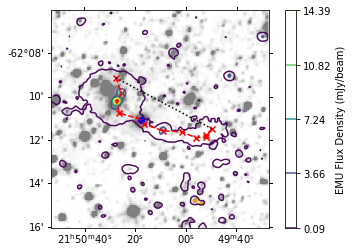

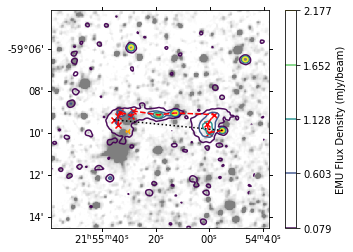

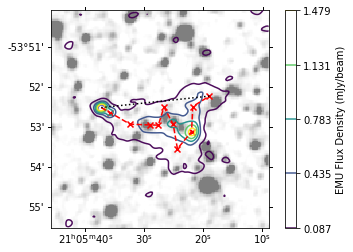

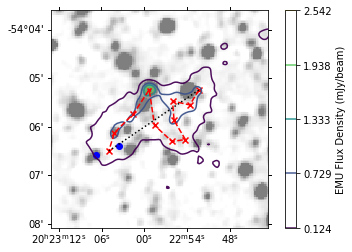

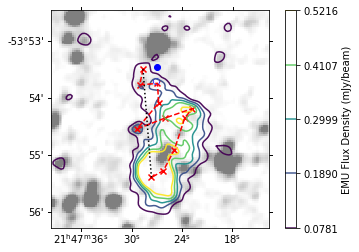

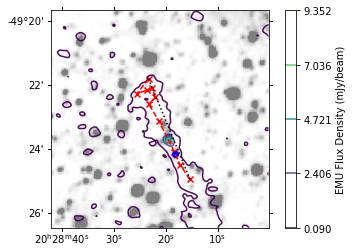

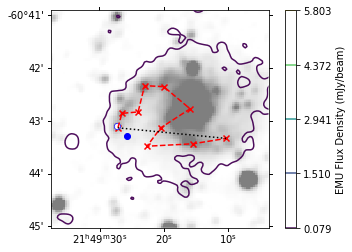

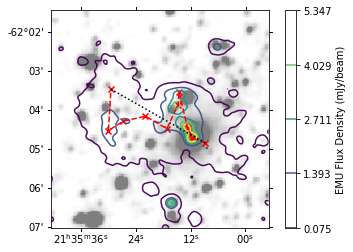

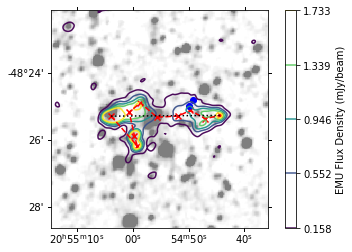

In [22]:
def nearby_wise(mean_component, max_sep = 7*u.arcminute):
    return np.argwhere(mean_component.separation(wise_positions) < max_sep)
    
def nearby_emu(mean_component, max_sep = 7*u.arcminute):
    return np.squeeze(np.argwhere(mean_component.separation(sub_emu_positions) < max_sep))
    


def make_postage_image(G, subg, count=0):
    
    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list(
            "mycmap",
            [(1, 1, 1, 1), (0.5, 0.5, 0.5, 1)]
        )
    
    emu_fits = fits.open('../Data/10_field_emu/image.i.emu-pilot-ten-tile.cont.taylor.0.restored.fits', 
                     memmap=True)
    emu_img = np.squeeze(emu_fits[0].data)
    emu_wcs = WCS(emu_fits[0].header).celestial
    
    subg = list(subg)
    
    data = min([d for d in G.edges(nbunch=subg, data=True)], key=lambda x:x[2]['count'])
    
    ir_hosts = data[2]['IR Host']
    
    components = sub_emu_positions[np.array(subg)]
    wise_srcs = wise_positions[ir_hosts]
    mean_component = SkyCoord(components.cartesian.mean())
    
    emu_sky_path = pu.SkyPath(components, max_iterations=2000000)
    
    emu_cutout = Cutout2D(emu_img, mean_component, size=10*u.arcminute, wcs=emu_wcs)
    wise_cutout = get_src_img(mean_component, 'wise', angular=2*emu_sky_path.maximum_distance[1])[0]
    
    emu_wcs = emu_cutout.wcs.celestial
    wise_wcs = WCS(wise_cutout.header).celestial
    
    nearby_emu_srcs = nearby_emu(mean_component)
    unrelated_emu = list(set(nearby_emu_srcs) - set(subg))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wise_wcs)
    
    emu_cutout.data = emu_cutout.data * 1000
    emu_rms = pu.rms_estimate(emu_cutout.data)
    
    cm = ax.contour(emu_cutout.data, 
               transform=ax.get_transform(emu_wcs),
                levels=np.arange(5)  * (0.99*np.nanmax(emu_cutout.data) - 3*emu_rms)/10 + 3*emu_rms ,
               cmap='viridis',
               alpha=0.95)
    
    ax.scatter(sub_emu_positions[unrelated_emu].ra,
               sub_emu_positions[unrelated_emu].dec,
               color='orange',
               marker='3',
               transform=ax.get_transform('fk5'),)
    
    ax.scatter(sub_emu_positions[subg].ra,
               sub_emu_positions[subg].dec,
               color='red',
               marker='x',
               transform=ax.get_transform('world'),
              )
    
    
    emu_sky_path.plot_shortest_path(ax, color='red', ls='--')
    emu_sky_path.plot_maximum_distance(ax, color='black', ls=':')
    
    ax.scatter(wise_srcs.ra, 
               wise_srcs.dec, 
               transform=ax.get_transform('world'), 
               color='blue')
    
    likely_host=False
    sky_matches = search_around_sky(components, wise_srcs, seplimit=15*u.arcsecond)
    if len(sky_matches[0]) > 0:
        best_match = np.argmin(sky_matches[2])
        best_wise_match = wise_srcs[sky_matches[1][best_match]]
        
        # Obtained from cross-matching a shifted catalogue to WISE
        if sky_matches[2][best_match] < 3.4*u.arcsecond:
            ax.scatter(best_wise_match.ra, 
                       best_wise_match.dec, 
                       transform=ax.get_transform('world'), 
                       color='white',
                       s=22)
            likely_host = True
    
    low, high = np.percentile(wise_cutout.data.flatten(), [25, 95])
    im = ax.imshow(wise_cutout.data, vmin=low, vmax=high, cmap=cmap)
    
    fig.colorbar(cm, label='EMU Flux Density (mJy/beam)')
    
    if likely_host:
        fig.savefig(f"{path.Collation_Coloured.Likely_IR}/{count}.png")  
    elif len(ir_hosts) > 5:
        fig.savefig(f"{path.Collation_Coloured.Unconstrained_IR}/{count}.png")
    elif len(ir_hosts) == 0:
        fig.savefig(f"{path.Collation_Coloured.No_IR}/{count}.png")
    else:
        fig.savefig(f"{path.Collation_Coloured.Acceptable_IR}/{count}.png")
    
    
for i, subg in enumerate(sorted(nx.connected_components(G), key=lambda x: len(x), reverse=True)):
    subg = list(subg)

    if i > 10:
        break
        
    make_postage_image( G, subg, count=i)
